Si ModuleNotFoundError: No module named 'tqdm' faire !pip install tqdm dans une cellule code

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
from tqdm import tqdm
import time
import GPUtil
import psutil

In [16]:
TRAIN_PATH = "../dataset/training_set"
TEST_PATH  = "../dataset/test_set"

In [17]:
MAX_FEATURES = 1500   # ORB keypoints
K = 300               # taille du vocabulaire visuel

In [1]:
class PerformanceTracker:
    def __init__(self):
        self.start_time = None
        self.logs = {}

    def start(self, name):
        self.start_time = time.time()
        self.cpu_start = psutil.cpu_percent(interval=None)
        self.mem_start = psutil.virtual_memory().used

    def stop(self, name):
        elapsed = time.time() - self.start_time
        cpu = psutil.cpu_percent(interval=None)
        mem = psutil.virtual_memory().used
        self.logs[name] = {
            "time_sec": elapsed,
            "cpu_percent": cpu,
            "ram_mb": mem / 1024**2
        }
        print(f"[{name}] Time: {elapsed:.1f}s | CPU: {cpu}% | RAM: {mem/1024**2:.0f} MB")

In [18]:
def load_images(folder_path):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(folder_path))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            labels.append(label)

    return image_paths, labels, class_names


train_paths, train_labels, class_names = load_images(TRAIN_PATH)
test_paths, test_labels, _ = load_images(TEST_PATH)

print("Classes :", class_names)
print("Train :", len(train_paths))
print("Test :", len(test_paths))


Classes : ['cats', 'dogs']
Train : 8000
Test : 2000


In [19]:
orb = cv2.ORB_create(
    nfeatures=MAX_FEATURES,
    scaleFactor=1.2,
    nlevels=8
)

In [20]:
def extract_orb(paths, labels):
    descriptors = []
    valid_labels = []

    for path, label in tqdm(zip(paths, labels), total=len(paths)):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        kp, des = orb.detectAndCompute(img, None)
        if des is not None:
            descriptors.append(des)
            valid_labels.append(label)

    return descriptors, np.array(valid_labels)


train_des, y_train = extract_orb(train_paths, train_labels)

100%|██████████| 8000/8000 [00:19<00:00, 411.27it/s]


In [21]:
tracker = PerformanceTracker()

tracker.start("ORB extraction (train)")
train_des, y_train = extract_orb(train_paths, train_labels)
print("Descripteurs test :", len(test_des))
tracker.stop("ORB extraction (train)")

100%|██████████| 2000/2000 [00:05<00:00, 385.79it/s]

Descripteurs test : 1997


In [22]:
all_train_des = np.vstack(train_des)

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=1000,
    random_state=42,
    n_init=10
)

tracker.start("KMeans vocab")
kmeans.fit(all_train_des)
tracker.stop("KMeans vocab")

print("Vocabulaire visuel créé :", K)

Vocabulaire visuel créé : 300


In [23]:
def build_histograms(des_list, kmeans, k):
    X = np.zeros((len(des_list), k))
    for i, des in enumerate(des_list):
        words = kmeans.predict(des)
        for w in words:
            X[i, w] += 1
    norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-8
    return X / norm

tracker.start("BoVW histograms")
X_train = build_histograms(train_des, kmeans, K)
X_test = build_histograms(test_des, kmeans, K)
tracker.stop("BoVW histograms")


print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (7987, 300)
X_test : (1997, 300)


In [24]:
param_grid = {
    'C': [10, 50],
    'gamma': ['scale', 0.005]
}

grid = GridSearchCV(
    SVC(kernel='rbf'),
    param_grid,
    cv=3,                
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

svm = grid.best_estimator_
print("Meilleurs paramètres :", grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleurs paramètres : {'C': 50, 'gamma': 0.005}


In [25]:
y_pred = svm.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nRapport de classification :\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy : 0.6930395593390085

Rapport de classification :

              precision    recall  f1-score   support

        cats       0.71      0.65      0.68       998
        dogs       0.68      0.73      0.71       999

    accuracy                           0.69      1997
   macro avg       0.69      0.69      0.69      1997
weighted avg       0.69      0.69      0.69      1997



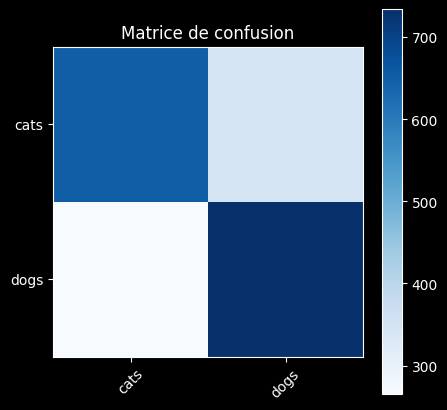

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title("Matrice de confusion")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.show()


In [27]:
output_dir = "chekpoints_ORB"

os.makedirs(output_dir, exist_ok=True)

joblib.dump(svm, os.path.join(output_dir, "svm_bovw_orb.pkl"))
joblib.dump(kmeans, os.path.join(output_dir, "kmeans_vocab.pkl"))

print("Modèle sauvegardé")

Modèle sauvegardé


In [29]:
checkpoint_dir = "chekpoints_ORB"

svm = joblib.load(os.path.join(checkpoint_dir, "svm_bovw_orb.pkl"))
kmeans = joblib.load(os.path.join(checkpoint_dir, "kmeans_vocab.pkl"))

# Conclusion

Nous avons mis en œuvre une approche de classification d’images basée sur des méthodes de Machine Learning classiques, combinant l’extraction de descripteurs locaux ORB, un modèle Bag of Visual Words et un classifieur SVM à noyau RBF.

Sur le dataset Dogs vs Cats, le modèle atteint une petite accuracy d’environ 69 %. Cette approche repose uniquement sur des motifs locaux et ne capture pas la structure globale des objets, ce qui entraîne certaines confusions entre les deux classes.

Mais, cette méthode présente plusieurs avantages notables : un coût de calcul réduit, une mise en œuvre simple, et une bonne stabilité, avec peu de risque de sur-apprentissage. Elle constitue ainsi une baseline pertinente et explicable, permettant de comparer efficacement les performances des approches Machine Learning classiques et Deep Learning dans le cadre de la classification d’images.